# Senior Wildfire Data Scientist

This take home exercise is designed for you to demonstrate technical competency with a short exercise.

We would like you to address the following prompts using the associated data file. We expect this exercise to take less than one hour depending on your familiarity with the APIs of Python packages like numpy, pandas and geopandas, shapely, and scikit-learn.

Please take extra care to fully read the prompts before beginning your work, as the final step is the most important.

## Submission instructions

1. Please submit a jupyter notebook with well-documented code, descriptive comments, and textual or visual outputs where necessary.
1. Please pay special attention to documenting your thought process. Tell us what you've learned, what questions arise, how you would build on this work, etc. 

## Prompts

### Description

A potential customer has provided Overstory with a data file containing ground-truth information from their network. They claim this data file has information on the location of their poles and lines, as well as counts of healthy and dead trees nearby those lines. They further claim that independent contractors have examined a subset of their network, and have rated lines as either low, medium, or high risk. We have no further information from the client as to how the healthy or dead tree counts were collected, how the risk ratings were generated, or generally how to interpret the data.

### Exploration

Your non-technical Overstory colleagues have a few questions about the data. Please feel free to use these questions as inspiration for exploring the data, and do not feel the need to dive deep on any particular question or uncover any profound patterns.
1. Can you say anything about the geographic distribution of the network? Please note there is no CRS with this data source, and the coordinates are completely fabricated.
1. Can we trust the counts of healthy and dead trees?
1. Are there any patterns to be found in the relationship between healthy and dead trees?
1. Are there any geographic patterns to be found in the distribution of healthy and dead trees?
1. What do the columns "*_near_line" mean?

### Modeling

Most importantly, it appears that only a subset of the risk ratings are available. Can we impress the customer by coming up with a model that predicts the risk ratings for the lines where risk rating is not available? Please show your work and communicate your confidence in this model. 

How would you recommend that your Overstory colleagues describe this work to the customer at their next meeting? Do you have any follow-up questions for the customer that would help you to extend your work?

# Setup Package Imports

In [1]:
import geopandas as gpd
import os
from matplotlib import pyplot as plt

# Read dataset and perform initial exploration

In [2]:
cwd = os.getcwd()
gdf = gpd.read_parquet(cwd+'/senior_wildfire_network_data.parquet')
print('columns\n',gdf.dtypes)
print('shape',gdf.shape)
print('head\n',gdf.head())

columns
 geometry                 geometry
tree_crowns               float64
dead_trees                float64
tree_crowns_near_line     float64
dead_trees_near_line      float64
risk                       object
dtype: object
shape (2517, 6)
head
                                                  geometry  tree_crowns  \
id                                                                       
2c9997  POLYGON ((3279033.158 228364.295, 3279032.478 ...          7.0   
b79db0  POLYGON ((3274243.292 229223.348, 3274241.510 ...         26.0   
e29aaf  POLYGON ((3277685.748 229360.692, 3277687.540 ...          2.0   
d9c9c5  POLYGON ((3280328.441 240473.400, 3280326.680 ...          7.0   
4f720b  POLYGON ((3261453.121 198662.801, 3261453.908 ...          0.0   

        dead_trees  tree_crowns_near_line  dead_trees_near_line    risk  
id                                                                       
2c9997        15.0                    0.0                   0.0    None  
b79db0    

We see that there are 2493 network segments with tree survey data. 
Counts of live and dead trees (`tree_crowns`, `dead_trees`) tend to be higher than live and dead trees near the utilitiy lines (`tree_crowns_near_line`, `dead_trees_near_line`).

In [3]:
gdf.describe()

,tree_crowns,dead_trees,tree_crowns_near_line,dead_trees_near_line
count,2493.000000,2493.000000,2493.000000,2493.000000
mean,8.152427,4.974729,0.056959,0.176895
std,7.250397,7.166653,0.243628,0.571174
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,7.000000,3.000000,0.000000,0.000000
75%,13.000000,5.000000,0.000000,0.000000
max,33.000000,47.000000,2.000000,4.000000


It appears that the risk assessment was done on 651 records - 26% of the data. Looking at a histogram of counts per risk category, risk folllows a pretty normal distribution with the medium category containing more than 50% of the line segments assessed.

Records with Risk scores: 651
As percent: 25.86%


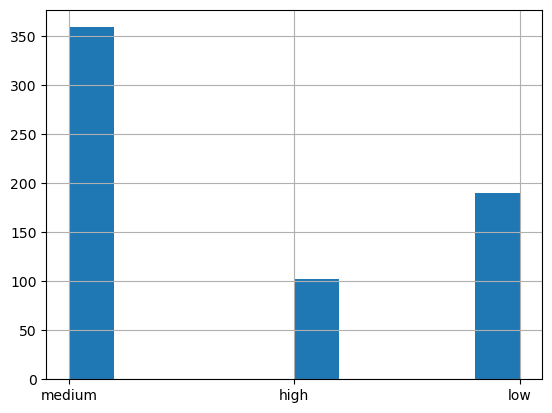

In [4]:
gdf.risk.hist()
print(f'Records with Risk scores: {(len(gdf) - gdf.risk.isna().sum())}')
print(f'As percent: {100*(len(gdf) - gdf.risk.isna().sum())/len(gdf):.2f}%')

# Explore the relationship between healthy and dead trees (Qs 2 & 3)

We must assume that the polyogns in this dataset are line buffers wherein trees were surveyed a certain distance from the network. Each line segment is of varying length making its survey area different. 

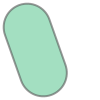

In [5]:
gdf.iloc[0].geometry

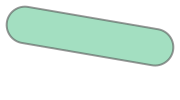

In [6]:
gdf.iloc[1].geometry

Even though there's no CRS we can still compute each polygon's area and see how these 'segment survey areas' relate to tree counts

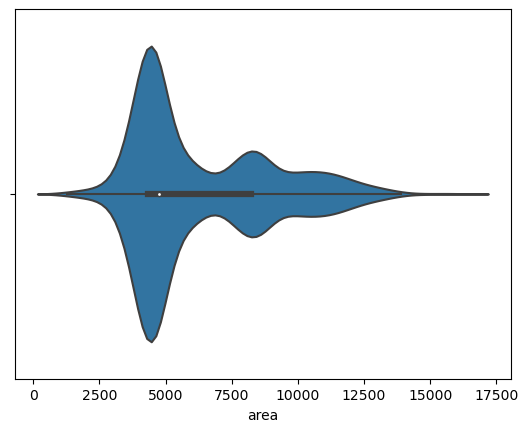

In [7]:
import seaborn as sns

# make an area column and plot a histogram of the areas 
# assume values to represent sq meters
gdf['area'] = gdf.geometry.area
sns.violinplot(x=gdf['area'])
plt.show()

Now we'll check out: 
* the relationship of the live to dead tree count in each segment area 
* segment area to live tree
* segment area to dead tree

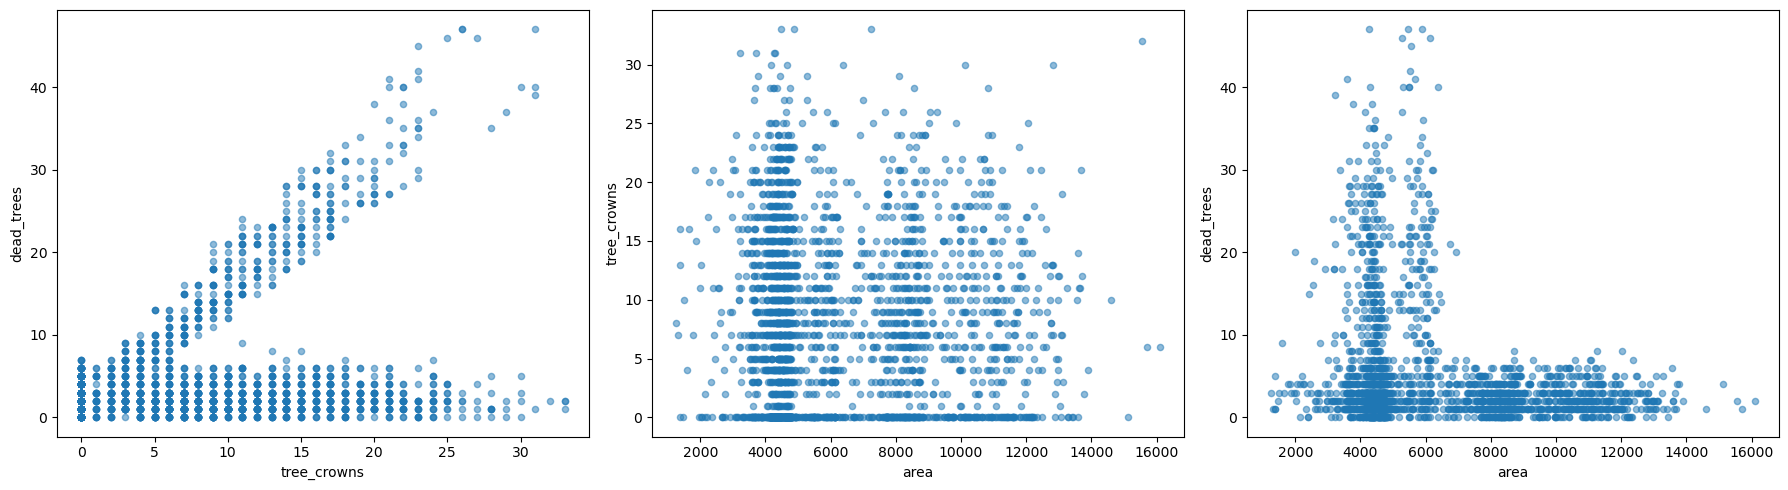

In [8]:
# Scatter plot tree crowns vs dead trees, 
# as well as the relationship between area of the surveyed segment area to live and dead tree counts
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scatter plot of tree_crowns vs dead_trees
gdf.plot.scatter(x='tree_crowns', y='dead_trees', alpha=0.5, ax=axes[0])

# Scatter plot of tree_crowns vs tree_crowns_near_line
gdf.plot.scatter(x='area', y='tree_crowns', alpha=0.5, ax=axes[1])

# Scatter plot of dead_trees vs dead_trees_near_line
gdf.plot.scatter(x='area', y='dead_trees', alpha=0.5, ax=axes[2])

plt.tight_layout()
plt.show()

The live to dead tree count scatterplot shows that there are sort of two patterns, 
1. segments where live and dead tree counts are very similar (1:1 diagonal)
2. segments where live trees far exceed dead trees.

In most real-world settings we expect to see these two patterns existing at the same time across a patchwork of human-environment influence. 

The pattern we don't see here (and don't expect to see) is where dead trees far exceed live trees, which we would really only ever see in a high-severity fire situation where everything including tree canopy is torched (in which case all aboveground utility assets would be torched too).

In terms of what we can expect from realistic count numbers, that's harder to judge - no species info or tree crown diameter, etc to gauge how many trees could realistically be counted in an area of X size. 

However, we do see in the far two right plots that the highest counts of live and dead tree counts occur in the 4000-8000 survey area range, which is the most frequently occurring size of segment. This is at least reassuring.

# 4. Are there any geographic patterns to be found in the distribution of healthy and dead trees?

its harder to get any insight from symbolizing the polygons (hard to see the colors on such skinny polygons).  
So we can plot them as points (polygon centroids) with a color gradient and transparency to make a nicer first visualization and pick apart the patterns. 

In [9]:
import numpy as np
# Compute the dot product of 'tree_crowns' and 'dead_trees' columns
gdf['live_dead_product'] = gdf['tree_crowns'] * gdf['dead_trees']
gdf['live_dead_diff'] = gdf['tree_crowns'] - gdf['dead_trees']
gdf['live_dead_sum'] = gdf['tree_crowns'] + gdf['dead_trees']

gdf['live_dead_ratio'] = gdf['tree_crowns'] / gdf['dead_trees']
gdf['live_dead_ratio'] = gdf['live_dead_ratio'].replace([np.inf, -np.inf], np.nan)
gdf['live_dead_ratio'] = gdf['live_dead_ratio'].fillna(0)

print(gdf[['tree_crowns','dead_trees','live_dead_diff','live_dead_sum','live_dead_ratio','live_dead_product']].head(5))

        tree_crowns  dead_trees  live_dead_diff  live_dead_sum  \
id                                                               
2c9997          7.0        15.0            -8.0           22.0   
b79db0         26.0        47.0           -21.0           73.0   
e29aaf          2.0         5.0            -3.0            7.0   
d9c9c5          7.0         3.0             4.0           10.0   
4f720b          0.0         1.0            -1.0            1.0   

        live_dead_ratio  live_dead_product  
id                                          
2c9997         0.466667              105.0  
b79db0         0.553191             1222.0  
e29aaf         0.400000               10.0  
d9c9c5         2.333333               21.0  
4f720b         0.000000                0.0  


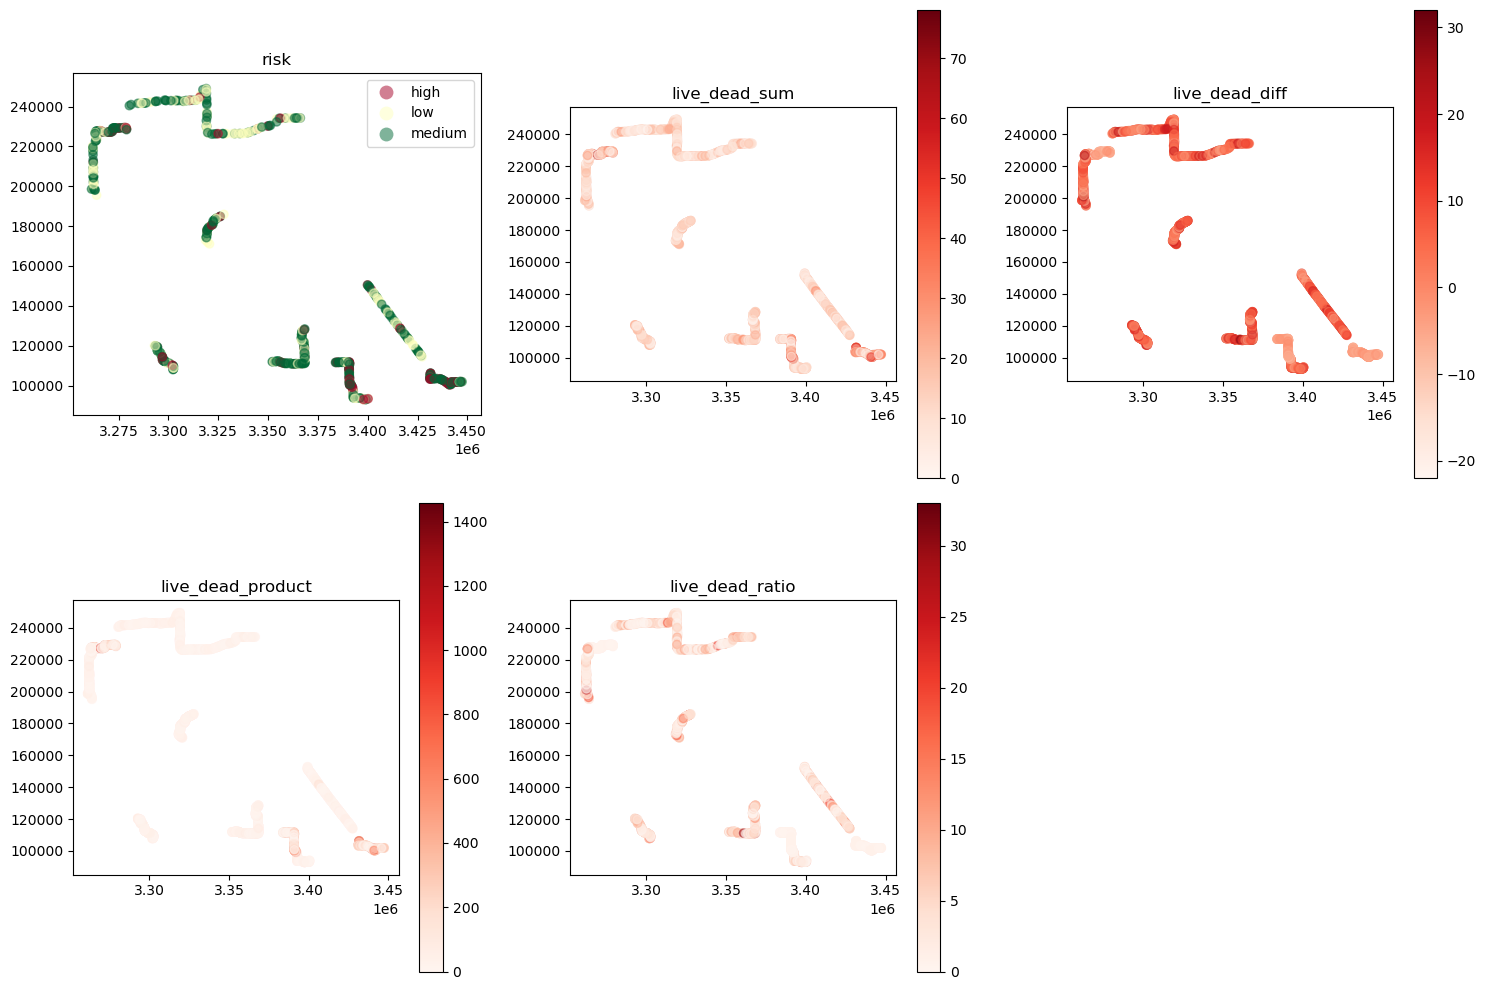

In [14]:
# plot a 2x3 subplot axis where each plot draws the dataset's centroids but symbolizes them by each of the columns
plt.colormaps()
gdf_plotter = gdf.copy() # make a copy of the dataframe so we can convert the geometry to centroids
gdf_plotter['geometry'] = gdf_plotter.centroid # convert the geometry to centroids

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
columns = ['risk','live_dead_sum','live_dead_diff','live_dead_product','live_dead_ratio']
# columns = ['risk', 'tree_crowns','dead_trees', 'tree_crowns_near_line','dead_trees_near_line']
for i, col in enumerate(columns):
    ax = axes[i // 3, i % 3]
    cmap = 'RdYlGn' if col == 'risk' else 'Reds'
    gdf_plotter.plot(column=col, 
             legend=True, 
             ax=ax, 
             alpha=0.5, 
             cmap=cmap)
    ax.set_title(col)

# Remove the empty subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

High risk network segments appear to correlate with higher values across the four tree-related columns, but especially live and dead trees near line.

High counts of `tree_crowns` and `dead_trees` don't necessarily lead to high risk if there are low counts of `tree_crowns_near_line` and `dead_trees_near_line`. 

Key Takeaways


So can we trust the live and dead tree counts? Most likely, but we would obviously want to hear more about the actual data collection process involved to feel better about using the data.

# 5. What do the columns '*near_line' mean?

This must be a certain linear buffer distance to the line but also most likely it is looking at distance of tree crown to the line in X,Y,Z axes. It could be done roughly in the field with some manual measurements or with LiDAR scanners  - airborne via manned or unmanned aircraft or even terrestrial LiDAR. 

Therefore within the specific buffer survey area of a line segment it seems like the data collection process was to count all live and dead trees, but to also count live and dead trees falling within that 'near_line' threshold distance. 